# Data

In [9]:
# https://www.analyticsvidhya.com/blog/2021/06/image-recognition-using-pytorch-lightning/
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
import torchvision
import torch
import cv2
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from random import randint
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt

# Load dataset

In [51]:
# Data train 
path_dir_train = 'datasets/diaretdb1_v_1_1/TRAINSET/ddb1_fundusimages'
path_mask_train = 'datasets/diaretdb1_v_1_1/TRAINSET/ddb1_groundtruth/hardexudates'
img_list_train = os.listdir(os.path.join(path_dir_train))

# Data test
path_dir_test = 'datasets/diaretdb1_v_1_1/TESTSET/ddb1_fundusimages'
path_mask_test = 'datasets/diaretdb1_v_1_1/TESTSET/ddb1_groundtruth/hardexudates'
img_list_test = os.listdir(os.path.join(path_dir_test))

In [ ]:
transformations = {
    'test': transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize((224,224)),
#                         transforms.Grayscale(1),
                        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                        transforms.ToTensor()]),
     'train': transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.Resize((224,224)),
                           transforms.RandomRotation(degrees = 45),
                           transforms.RandomHorizontalFlip(p = 0.005),
                           transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#                            transforms.Grayscale(1),
                           transforms.ToTensor()
                           ])
}


# Class Dataset

In [23]:

class RD_SegmentationDataset(Dataset):
    def __init__(self, img_list, image_dir, mask_dir, transform=None, target_transform=None):
        
        self.data_list = img_list
        self.data_img = image_dir
        self.data_mask = mask_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):

        path_image = os.path.join(self.data_img, self.data_list[idx])
#         print(path_image)
        image = cv2.cvtColor(cv2.imread(path_image), cv2.COLOR_BGR2RGB)        
        image = cv2.resize(image, (224,224))
        image = torch.as_tensor(image, dtype=torch.uint8)
        image = image.permute(2,0,1)

        path_mask = os.path.join(self.data_mask, self.data_list[idx])
#         print(path_mask)
        mask = cv2.imread(path_mask,0)
        mask = cv2.resize(mask, (224,224))
        mask = cv2.threshold(mask, 240, 255, cv2.THRESH_BINARY)[1]
        mask = mask/255
        
        mask = np.expand_dims(mask, 2)
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.permute(2,0,1)

        return {'image':image, 'mask':mask}
    
RD_dataset = RD_SegmentationDataset(img_list_train, path_image, path_mask, transformations['train'])
RD_dataloader = DataLoader(RD_dataset, batch_size=4, shuffle=True)

torch.Size([4, 3, 224, 224])


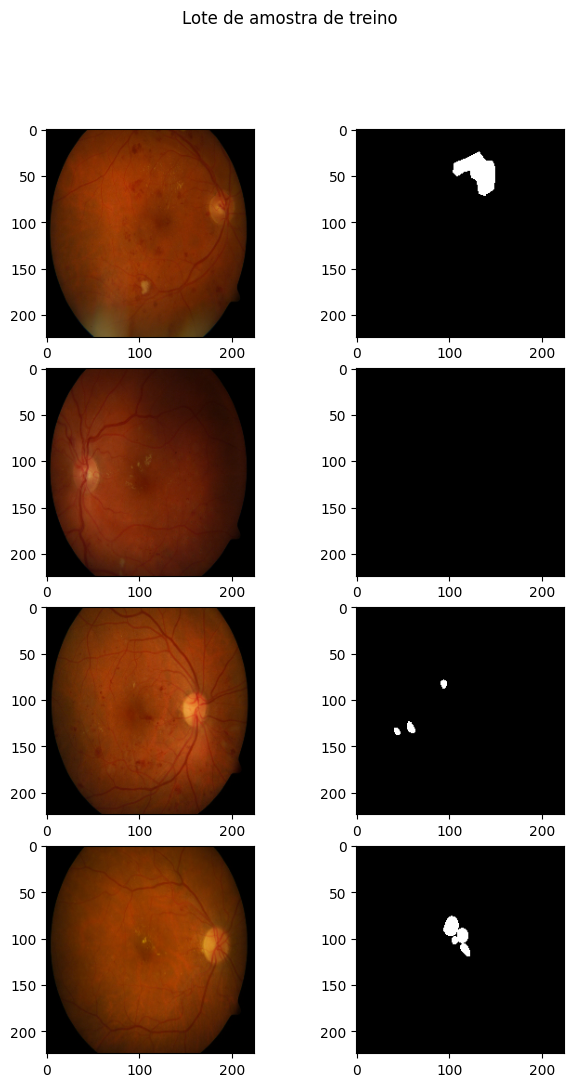

In [46]:
# Get a batch of training data
batch = next(iter(RD_dataloader))
inputs = batch['image']
masks = batch['mask']
print(inputs.shape)


fig, axs  = plt.subplots(4,2, figsize=(12,12))
fig.subplots_adjust(wspace=-0.5, hspace=0.15)
for ax, i in zip(axs, range(len(axs))):
    ax[0].imshow(np.transpose(inputs[i], (1,2,0)))
    ax[1].imshow(np.transpose(masks[i], (1,2,0))[:,:,0], cmap="gray")
fig.suptitle("Lote de amostra de treino")
plt.show()


In [54]:
import pytorch_lightning as pl
class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        return optimizer

    def prepare_batch(self, batch):
        inputs = batch["image"].float()
        masks = batch["mask"].float()
        return inputs, masks
#         return batch["image"] , batch["mask"]

    def infer_batch(self, batch):
        x, y = self.prepare_batch(batch)
        y_hat = self.net(x)
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        return loss

In [55]:
import monai

unet = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(8, 16, 32,64),
    strides=(2, 2, 2),
)

model = Model(
    net=unet,
    criterion=monai.losses.DiceCELoss(softmax=True),
    learning_rate=1e-2,
    optimizer_class=torch.optim.AdamW,
)
early_stopping = pl.callbacks.early_stopping.EarlyStopping(
    monitor="train_loss",
)
trainer = pl.Trainer(
    gpus=0,
#     precision='bf16',
    callbacks=[early_stopping]
)
trainer.logger._default_hp_metric = False

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


# Train

In [56]:
from datetime import datetime

train_set = RD_SegmentationDataset(img_list = img_list_train, 
                                   image_dir = path_dir_train, 
                                   mask_dir = path_mask_train, 
                                   transform = transformations['train'])
test_set = RD_SegmentationDataset(img_list = img_list_test, 
                                   image_dir = path_dir_test, 
                                   mask_dir = path_mask_test, 
                                   transform = transformations['test'])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=True)

start = datetime.now()
print("Training started at", start)
trainer.fit(model=model, train_dataloaders=train_loader)

print("Training duration:", datetime.now() - start)


  | Name      | Type       | Params
-----------------------------------------
0 | net       | UNet       | 40.8 K
1 | criterion | DiceCELoss | 0     
-----------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Training started at 2023-04-07 14:16:19.039103


c:\Users\ermes\OneDrive\Área de Trabalho\UNet-SegRD\my-env\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\ermes\OneDrive\Área de Trabalho\UNet-SegRD\my-env\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

c:\Users\ermes\OneDrive\Área de Trabalho\UNet-SegRD\my-env\lib\site-packages\monai\losses\dice.py:138: UserWarning: single channel prediction, `softmax=True` ignored.
  warnings.warn("single channel prediction, `softmax=True` ignored.")


Training duration: 0:00:06.310679


In [57]:
%tensorboard --logdir lightning_logs

UsageError: Line magic function `%tensorboard` not found.


In [58]:
model.to("cpu")
all_dices = []
get_dice = monai.metrics.DiceMetric(include_background=False, reduction="none")
with torch.no_grad():
    for batch in train_loader:
        inputs, targets = model.prepare_batch(batch)
        logits = model.net(inputs.to(model.device))
        labels = logits.argmax(dim=1)
        labels_one_hot = torch.nn.functional.one_hot(labels).permute(0, 4, 1, 2, 3)
        get_dice(labels_one_hot.to(model.device), targets.to(model.device))
    metric = get_dice.aggregate()
    get_dice.reset()
    all_dices.append(metric)
all_dices = torch.cat(all_dices)

RuntimeError: number of dims don't match in permute